В данной работе с помощью датасета реестра предпринимателей из ФНС отберем юридические лица малого и среднего бизнеса в области Строительства, спарсим необходимые данные с сайта государственной бухгалтерской отчетности, после чего посчитаем EBIT по годам, посмотрим на чистую прибыль компаний с 2020 по 2024 год и нанесем 500 компаний по чистой прибыли за 2024 год на карту. Для работы возьмем первые 150000 строк, чтобы вычисления занимали разумное время.

In [599]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
warnings.filterwarnings("ignore")

In [608]:
df=pd.read_csv('output.csv', nrows=150000, header=2)
df.head()

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.10.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
1,2,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.08.2018,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
2,3,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1025204418293,5263039399,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,10.07.2022,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
3,4,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,1025204411682,5263025484,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,1.0
4,5,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,1037800039276,7801123215,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.07.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN


In [609]:
df.shape

(150000, 23)

Отберем подходящие нам объекты

In [610]:
df_filter=df[(df['Тип субъекта']=='Юридическое лицо') \
          & ((df['Категория']=='Малое предприятие') | (df['Категория']=='Среднее предприятие')) \
          & (df['Основной вид деятельности']=='41.20 Строительство жилых и нежилых зданий')]

In [611]:
df_filter.shape

(716, 23)

Для парсинга данных с сайта бухгалтерской отчетности создадим две функции, одна из них будет возвращать два списка: список показателя EBIT с 2020 по 2024 года, список чистой прибыли с 2020 по 2024 года. При отсутствии данных заполним пропуски нулями. Другая функция будет возвращать координаты регистрации предпринимателя. Так как процесс парсинга не быстрый, положим все данные в csv файл, чтобы не потерять их и далее работать с ними.

In [612]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "X-Requested-With": "XMLHttpRequest"
    }
session = requests.Session()

def get_cp_ebit(x):
    res = session.get(f"https://bo.nalog.gov.ru/advanced-search/organizations/search?query={x}&page=0&size=20", timeout=5, headers=headers).json()
    if res["content"]==[]:
        return pd.Series([[],[]])
    org_id = res["content"][0]["id"]
    response = session.get(f"https://bo.nalog.gov.ru/nbo/organizations/{org_id}/bfo/", timeout=5, headers=headers).json()

    try:
        lis_cp=[]
        for year in response:
            try:
                lis_cp.append(year['typeCorrections'][0]['correction']['financialResult']['current2400'])
            except:
                lis_cp.append(0)
    except:
        lis_cp=[]
    try:
        lis_ebit=[]
        for year in response:
            try:
                lis_ebit.append(year['typeCorrections'][0]['correction']['financialResult']['current2300'] \
                           + year['typeCorrections'][0]['correction']['financialResult']['current2330'] \
                           - year['typeCorrections'][0]['correction']['financialResult']['current2320'])
            except:
                lis_ebit.append(0)
    except:
        lis_ebit=[]
    
    return pd.Series([lis_ebit, lis_cp])


        

def get_coords(x):
    res = session.get(f"https://bo.nalog.gov.ru/advanced-search/organizations/search?query={x}&page=0&size=20", timeout=5, headers=headers).json()
    if res["content"]==[]:
        return pd.Series([None, None])
    org_id = res["content"][0]["id"]
    response_1=session.get(f'https://bo.nalog.gov.ru/nbo/organizations/{org_id}', timeout=5, headers=headers).json()
    try:
        return pd.Series([response_1['location']['latitude'], response_1['location']['longitude']])
    except:
        return pd.Series([None, None])


df_filter[['EBIT', 'Чистая прибыль']]=df_filter['ИНН'].apply(get_cp_ebit)
df_filter[[ 'Широта', 'Долгота']]=df_filter['ИНН'].apply(get_coords)

df_filter.to_csv('data.csv', index=False)

Обработаем спарсенный датасет, так как списки показателей EBIT и чистой прибыли не обязательно состоят из 5 элементов (для некоторых предпринимателей отчетность за некоторые года может отсутсвовать), дополним все списки до 5 элементов с помощью функции years, после чего разобьем каждый список на 5 новых признаков, каждый из которых отражает показатель предпринимателя/компании за конкретный год (итого 10 новых признаков). Также посчитаем процентный прирост чистой прибыль с 2020 по 2024 год.

In [829]:
def years(x):
    lis=list()
    x=x[1:-1]
    if len(x)>2:
        for i in x.split(','):
            j=float(i)
            lis.append(i)
    while len(lis)<5:
        lis.append(0)
    return pd.Series(lis, dtype='float64')

df_pars=pd.read_csv('data.csv')

df_pars[['EBIT 2024','EBIT 2023','EBIT 2022','EBIT 2021','EBIT 2020']]=df_pars['EBIT'].apply(years)
df_pars[['Чистая прибыль 2024', 'Чистая прибыль 2023','Чистая прибыль 2022','Чистая прибыль 2021','Чистая прибыль 2020']]=df_pars['Чистая прибыль'].apply(years)

df_pars['2024-2020 Рост чистой прибыли']=round((df_pars['Чистая прибыль 2024']-df_pars['Чистая прибыль 2020'])/abs(df_pars['Чистая прибыль 2020'])*100)

df_pars.head()

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,EBIT 2023,EBIT 2022,EBIT 2021,EBIT 2020,Чистая прибыль 2024,Чистая прибыль 2023,Чистая прибыль 2022,Чистая прибыль 2021,Чистая прибыль 2020,2024-2020 Рост чистой прибыли
0,20,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,NaN,...,-27628.0,10819.0,1060.0,10397.0,-20129.0,-20913.0,19518.0,3080.0,-8543.0,-136.0
1,52,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,г Дзержинский,...,709167.0,32110.0,0.0,0.0,28998.0,582441.0,31442.0,20376.0,29618.0,-2.0
2,4653,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",Юридическое лицо,Малое предприятие,1021400692048,1414006922,41.20 Строительство жилых и нежилых зданий,77 - г.Москва,NaN,NaN,...,0.0,0.0,0.0,-3607.0,54850.0,19889.0,3375.0,2092.0,-5382.0,1119.0
3,4668,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",Юридическое лицо,Малое предприятие,1043301806415,3327332190,41.20 Строительство жилых и нежилых зданий,33 - Владимирская область,NaN,г Владимир,...,0.0,0.0,0.0,0.0,47723.0,40101.0,30374.0,20565.0,18957.0,152.0
4,4674,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",Юридическое лицо,Малое предприятие,1027807999988,7816061297,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,0.0,0.0,0.0,0.0,11674.0,565.0,444.0,1077.0,5273.0,121.0


Будем строить график, отражающий количество компаний с разными (округленными) значениями процента роста чистой прибыли за период с 2020 по 2024 год. Для этого избавимся от компаний, имеющих в качестве значения процента NaN или inf. Посмотрим на статистику колонки процента роста чистой прибыли.

In [830]:
df_cl=df_pars[(df_pars['2024-2020 Рост чистой прибыли'].notnull()) & (~np.isinf(df_pars['2024-2020 Рост чистой прибыли']))]
df_cl['2024-2020 Рост чистой прибыли'].describe()

count       601.000000
mean       3018.655574
std       43461.810858
min     -605108.000000
25%         -97.000000
50%           1.000000
75%         263.000000
max      663450.000000
Name: 2024-2020 Рост чистой прибыли, dtype: float64

Видим, что в датасете есть компании с процентным приростом (убытком) прибыли, исчисляемым сотнями тысяч. Можно предположить, что это компании, только начавшие свою деятельность в 2020 году или позже, будем считать такие компании выбросами. Выбросы разносят среднее значение прироста процента, делая его не показательным. Поэтому визуализируем только компании с процентным приростом (убытком) от -1000 до 1000 процентов.

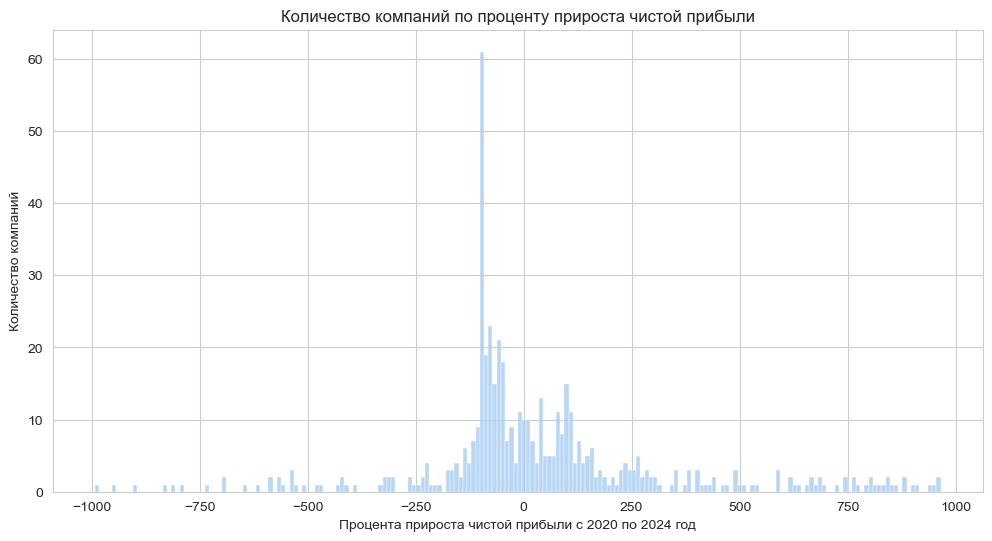

In [831]:
df_cl=df_cl[(df_cl['2024-2020 Рост чистой прибыли']>-1000) & (df_cl['2024-2020 Рост чистой прибыли']<1000)]

sns.set_style(style="whitegrid")
sns.set_palette("pastel")


plt.figure(figsize=(12, 6))
plt.xlabel('Процента прироста чистой прибыли с 2020 по 2024 год')
plt.ylabel('Количество компаний')
plt.title('Количество компаний по проценту прироста чистой прибыли')
sns.histplot(x='2024-2020 Рост чистой прибыли', data=df_cl, bins=200)
plt.show()

Вывод: наблюдаем следующую картину: большое количество компаний немного упали в чистой прибыли за прошедшие 4 года, однако количество компаний с крупным приростом чистой прибыль больше, чем количество компаний с крупным упадком чистой прибыли. В связи с этим средний прирост чистой прибыли находится около нуля. За 4 года компании в строительной сфере испытали резкий спад на фоне начала СВО и резкий подъем в 2023 году, в связи с чем количество компаний с огромным упадком чистой прибыли не так велико, однако большинство компаний все еще не вышли на чистую прибыль уровня 2020 года, в то время как некоторые компании смогли подстроиться под обстоятельства и стабильно расти. Можно предположить, что последнее меньшинство компаний - гиганты отрасли, устойчивые к перепадам рынка либо компании, только начавшие расти в период с 2020 по 2024 года.

Далее построим два графика: изменение показателя EBIT с 2020 по 2024 год (в абсолютных значениях) и прирост EBIT по отношению к предыдущему году (для 2020 = 0, считаем этот год за базовый). EBIT считаем суммарно для всей строительной отрасли.

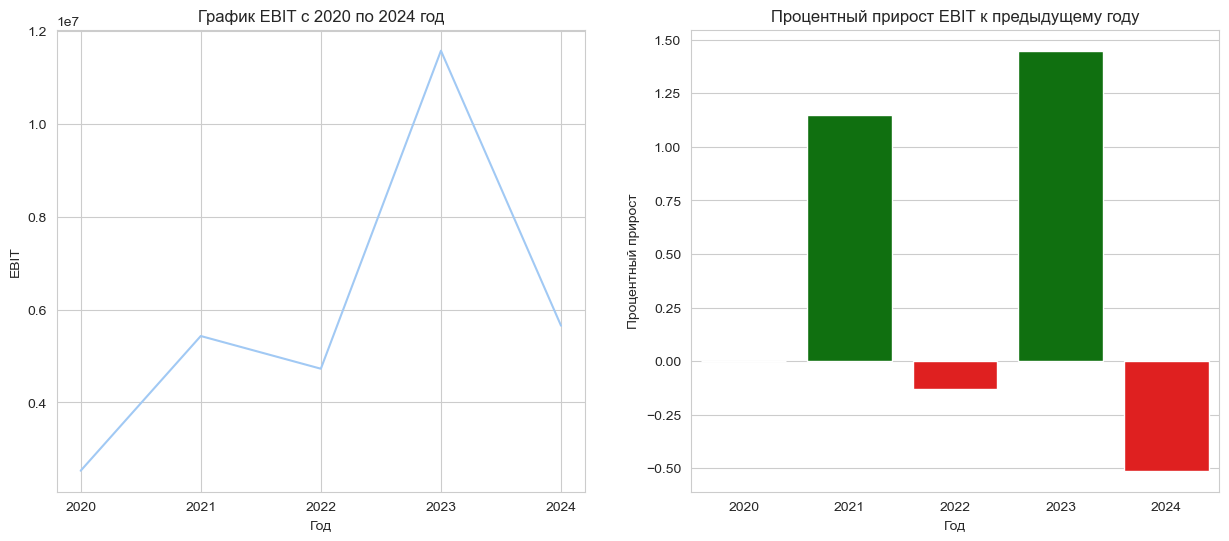

In [832]:
x=[2020,2021,2022,2023,2024]
y=pd.Series([df_pars['EBIT 2020'].sum(), df_pars['EBIT 2021'].sum(),df_pars['EBIT 2022'].sum(),df_pars['EBIT 2023'].sum(),df_pars['EBIT 2024'].sum()])
plt.subplots(1,2, figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(x,y)
plt.xticks(x)
plt.xlabel('Год')
plt.ylabel('EBIT')
plt.title('График EBIT с 2020 по 2024 год')

plt.subplot(1,2,2)
y1=pd.Series([0, (y[1]-y[0])/y[0], (y[2]-y[1])/y[1], (y[3]-y[2])/y[2], (y[4]-y[3])/y[3]])
sns.barplot(x=x,y=y1, palette=np.where(y1 >= 0, "green", "red"))
plt.xlabel('Год')
plt.ylabel('Процентный прирост')
plt.title('Процентный прирост EBIT к предыдущему году')

plt.show()

Вывод: Данные графики позволяют сделать комплексные выводы по состоянию строительной сферы за 2020-2024 года. Можно увидеть, что в 2021 году наблюдался стабильный умеренный рост по сравнению с 2020 годом, однако в 2022 году рост сменился падением рынка, в связи с началом СВО. 2023 ознаменовался резким скачком строительного сектора. Это можно обьяснить адаптацией отрасли к новым реалиям (снижение себестоимости за счет импортнозамещения), льготными условиями ипотеки, стимулирующими спрос на жилье. 2024 год отражает скачок отрасли в обртаную сторону. Это можно объяснить политикой ЦБ РФ, нацеленной на снижение инфляции (а следовательно и совокупного выпуска) за счет повышения ключевой ставки. 

Наконец, нанесем на карту топ-500 компаний по суммарной чистой прибыль за 2020-2024 года.

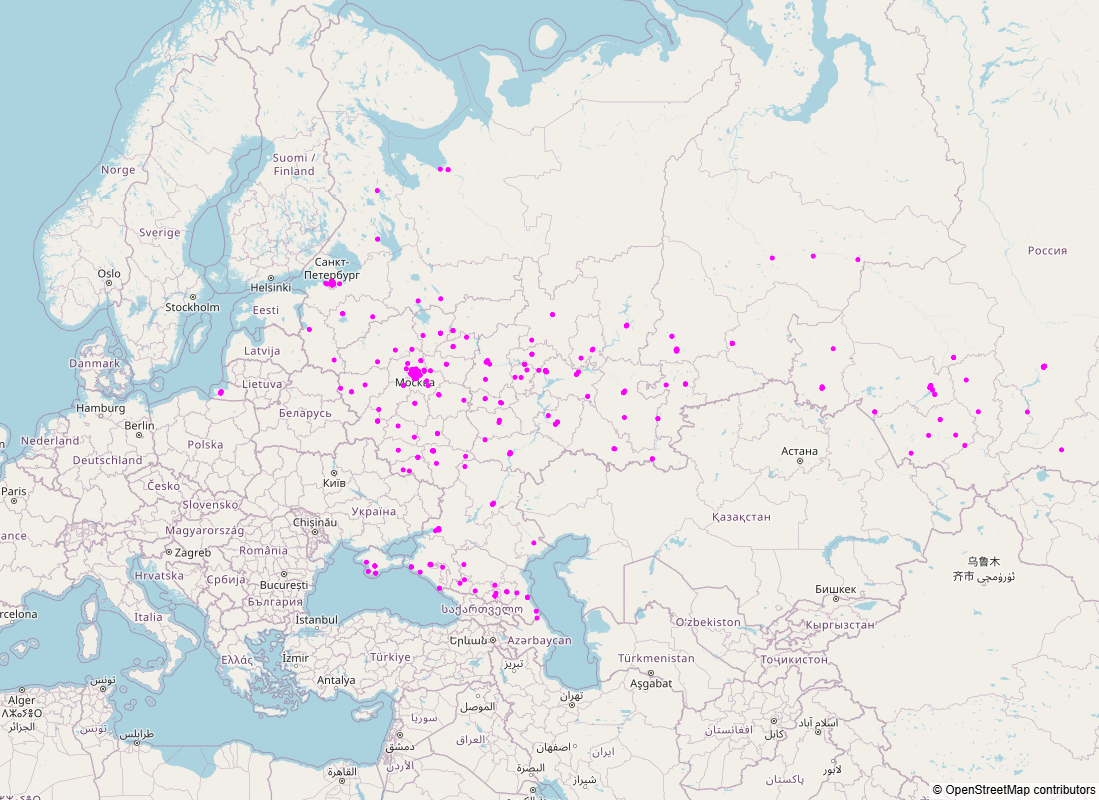

In [846]:
df_map=df_pars.copy()
df_map['Чистая прибыль сумма']=df_pars['Чистая прибыль 2024']+df_pars['Чистая прибыль 2020']\
     +df_pars['Чистая прибыль 2023']+df_pars['Чистая прибыль 2022']+df_pars['Чистая прибыль 2021']
df_map=df_map.sort_values('Чистая прибыль сумма', ascending=False).iloc[0:500]

fig = px.scatter_map(df_map, lat="Широта", lon="Долгота", hover_name='Город', hover_data='Чистая прибыль сумма', color_discrete_sequence=["fuchsia"], zoom=3, height=800)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()